In [57]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# Selenium の Chrome ドライバをヘッドレスモードで起動
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# 対象の URL
url = 'https://www.realclearpolling.com/polls/state-of-the-union/direction-of-country'
driver.get(url)

# テーブルが存在するまで待機（最大10秒）
try:
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'table.w-full'))
    )
except Exception as e:
    print("テーブルが見つかりませんでした:", e)
    driver.quit()
    exit()

# 動的コンテンツが読み込まれるまでさらに待機（必要に応じて調整）
time.sleep(5)

# ページソースを取得し、BeautifulSoup で解析
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

# "w-full" クラスのテーブルをすべて取得し、2つ目をターゲットとする
tables = soup.find_all('table', class_='w-full')
if len(tables) < 2:
    driver.quit()
    raise ValueError("ターゲットとなる2つ目のテーブルが見つかりません。")
target_table = tables[1]

# ターゲットテーブル内の各行のデータを抽出（6列分）
rows_data = []
for tr in target_table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue  # ヘッダー行や空行はスキップ
    row = []
    for i, td in enumerate(tds):
        # セル内のテキストを取得（不要な空白は削除）
        text = td.get_text(separator=' ', strip=True)
        if ":: after" in text:
            text = text.split(":: after")[0].strip()
        # 6列目（インデックス 5）の場合、内部の <span> 要素から数値部分のみ取得
        if i == 5:
            span_elements = td.find_all('span')
            if span_elements:
                text = span_elements[-1].get_text(strip=True)
        row.append(text)
    # 行が6セル以上ある場合は先頭6セルのみ採用
    if len(row) >= 6:
        rows_data.append(row[:6])
    else:
        rows_data.append(row)

print("取得した行数:", len(rows_data))

# ここでは6列分のデータがあると仮定して、6つのカラム名を設定
columns = ["Pollster", "Date", "Sample", "Right Direction", "Wrong Track", "Spread"]

# ヘッダー行が含まれている場合は除外（ここでは rows_data[1:] を使用）
if len(rows_data) > 1:
    df = pd.DataFrame(rows_data[1:], columns=columns)
else:
    df = pd.DataFrame(rows_data, columns=columns)

print(df)

# ブラウザを閉じる
driver.quit()


取得した行数: 3155
                       Pollster         Date   Sample Right Direction  \
0              Economist/YouGov  2/16 - 2/18  1451 RV              41   
1             Rasmussen Reports   2/9 - 2/13  2004 LV              46   
2              Economist/YouGov   2/9 - 2/11  1430 RV              38   
3             Rasmussen Reports    2/2 - 2/6  2078 LV              45   
4              Economist/YouGov    2/2 - 2/4  1423 RV              40   
...                         ...          ...      ...             ...   
3149                    NBC/WSJ   7/8 - 7/11                       34   
3150  Westhill Partners/Hotline   7/7 - 7/10                       31   
3151        Democracy Corps (D)  6/20 - 6/26                       36   
3152                      Zogby  6/20 - 6/22                       43   
3153                     Gallup  6/16 - 6/19                       42   

     Wrong Track Spread  
0             49     -8  
1             47     -1  
2             53    -15  
3     

In [58]:
temp =[s.split(' - ') for _,s in enumerate(df['Date'].to_list())]
tempX = []

year1 = datetime.today().year
year2 = year1
month = str(datetime.today().month).zfill(2)

for i in range(len(temp)):
    PeriodStart = ''.join([s.zfill(2) for s in temp[i][0].split('/')])
    PeriodEnd = ''.join([s.zfill(2) for s in temp[i][1].split('/')])
    tempX.append([PeriodStart,PeriodEnd])
chk1 = 1
chk2 = 1
for i,s in enumerate(tempX):
    if i==0:
        if month<s[0][:2]:
            year1 += -1
        if month<s[1][:2]:
            year2 += -1        
    else:
        if (s[0][:2]>tempX[i-1][0][4:6])and(s[0][:2]=="12"):
            year1 += -1
        if s[1][:2]>tempX[i-1][1][4:6]and(s[1][:2]=="12"):
            year2 += -1

    tempX[i][0]=str(year1)+s[0]
    tempX[i][1]=str(year2)+s[1]
    tempX[i].append(tempX[i][0]<=tempX[i][1])

# エラーがなければ空リストが表示されます
[print(s) for s in tempX if not s[2]==True]  


[]

In [61]:
temp = pd.DataFrame([s[:2] for s in tempX])
temp.columns = ['PeriodStart','PeriodEnd']
temp.tail()

,PeriodStart,PeriodEnd
3149,20040708,20050711
3150,20040707,20050710
3151,20040620,20050626
3152,20040620,20050622
3153,20040616,20050619


In [62]:
pd.concat([df,temp],axis=1).tail()

,Pollster,Date,Sample,Right Direction,Wrong Track,Spread,PeriodStart,PeriodEnd
3149,NBC/WSJ,7/8 - 7/11,,34,52,-18,20040708,20050711
3150,Westhill Partners/Hotline,7/7 - 7/10,,31,54,-23,20040707,20050710
3151,Democracy Corps (D),6/20 - 6/26,,36,56,-20,20040620,20050626
3152,Zogby,6/20 - 6/22,,43,53,-10,20040620,20050622
3153,Gallup,6/16 - 6/19,,42,56,-14,20040616,20050619


In [63]:
pd.concat([df,temp],axis=1).to_excel('RCP_direction.xlsx')

#### ファイルを読み込んで図示

In [17]:
import pandas as pd
from datetime import datetime
import japanize_matplotlib

def make_graph(df,weeks=1):
    dayday = str(datetime.today().year)
    dayday += str(datetime.today().month).zfill(2)
    dayday += str(datetime.today().day).zfill(2)

    idx = [str(s).replace('-','') for s in pd.period_range(start='20250120',end=dayday,freq='d').to_list()][::-1]

    averages = {}
    for id1 in idx:

        # s を日付型に変換し、1週間前の日付 id2 を生成
        current_date = pd.to_datetime(id1, format="%Y%m%d")
        id2 = (current_date - pd.Timedelta(weeks=weeks)).strftime("%Y%m%d")

        # df の各行が、PeriodStart <= id2 かつ PeriodEnd >= id を満たすものを抽出
        subset = df[((int(id2) <= df["PeriodEnd"]) & (df["PeriodEnd"] <= int(id1)))|((int(id2) <= df["PeriodStart"]) & (df["PeriodStart"] <= int(id1)))]

        averages[id1] = {"Right":subset["Right Direction"].mean(),"Wrong":subset["Wrong Track"].mean()}

    dfx = pd.DataFrame(averages).T
    dfx.index = pd.to_datetime(dfx.index, format='%Y%m%d')
    dfx = dfx.interpolate()

    return dfx


In [20]:
df = pd.read_excel('RCP_direction.xlsx')
df.head()


,Unnamed: 0,Pollster,Date,Sample,Right Direction,Wrong Track,Spread,PeriodStart,PeriodEnd
0,0,Economist/YouGov,2/16 - 2/18,1451 RV,41,49,-8,20250216,20250218
1,1,Rasmussen Reports,2/9 - 2/13,2004 LV,46,47,-1,20250209,20250213
2,2,Economist/YouGov,2/9 - 2/11,1430 RV,38,53,-15,20250209,20250211
3,3,Rasmussen Reports,2/2 - 2/6,2078 LV,45,48,-3,20250202,20250206
4,4,Economist/YouGov,2/2 - 2/4,1423 RV,40,50,-10,20250202,20250204


<Axes: >

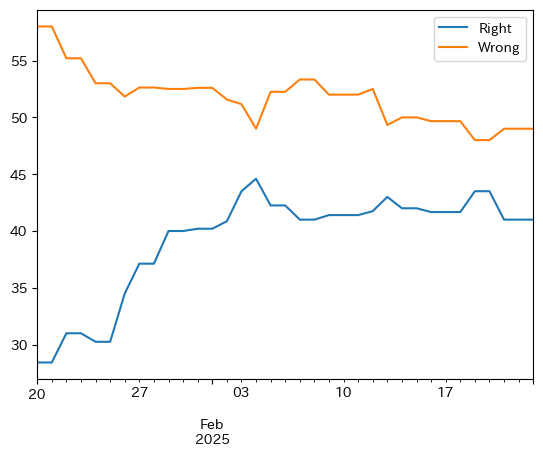

In [21]:
make_graph(df).plot()